In [1]:
%load_ext autoreload
%autoreload 2

In [180]:
import akantu as aka
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import (get_theoretical_contact_radius,
                    get_theoretical_normal_displacement,
                    plot_mesh)

In [196]:
mesh_file = 'mesh/contact3d_sphere.msh'
material_file = 'material/material.dat'
spatial_dimension = 3
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.2, aka._y), 'secondary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'secondary_fixed')

internodes_model = ContactMechanicsInternodes(spatial_dimension, mesh, model, 'primary_candidates', 'secondary_candidates')

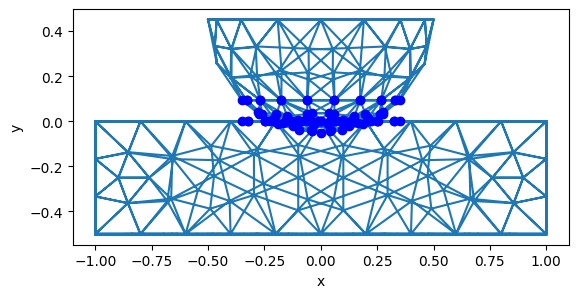

----> Starting iteration 1 <----
Interpenetrating nodes:  []
Nodes in tension:  [ 18  99 105 134 140 142]


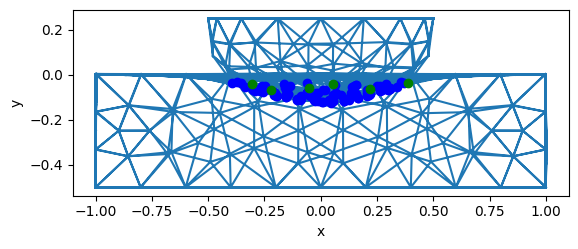

----> Starting iteration 2 <----
Interpenetrating nodes:  []
Nodes in tension:  [132]


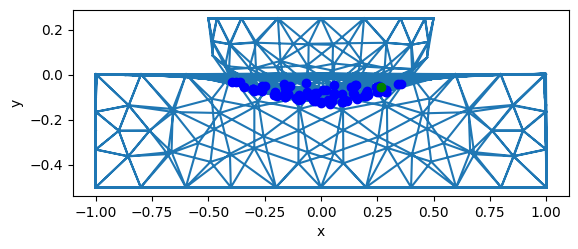


successfully converged in 2 iterations


In [197]:
# Plot initial configuration
nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
plot_mesh(internodes_model.mesh.getNodes(), internodes_model.mesh.getConnectivity(aka._triangle_3), nodes_interface)

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    nodes_interface_primary_old = internodes_model.nodes_interface_primary
    nodes_interface_secondary_old = internodes_model.nodes_interface_secondary

    # Find the interface nodes
    internodes_model.find_interface_nodes()

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged = internodes_model.update_interface(displacements, lambdas)

    nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
    nodes_interpenetrating = np.union1d(
        np.setdiff1d(internodes_model.nodes_interface_primary, nodes_interface_primary_old),
        np.setdiff1d(internodes_model.nodes_interface_secondary, nodes_interface_secondary_old))
    nodes_tension = np.union1d(
        np.setdiff1d(nodes_interface_primary_old, internodes_model.nodes_interface_primary),
        np.setdiff1d(nodes_interface_secondary_old, internodes_model.nodes_interface_secondary))
    print("Interpenetrating nodes: ", nodes_interpenetrating)
    print("Nodes in tension: ", nodes_tension)

    # Plot the obtained solution
    positions_new = internodes_model.mesh.getNodes() + displacements
    plot_mesh(positions_new, internodes_model.mesh.getConnectivity(aka._triangle_3), nodes_interface, nodes_interpenetrating, nodes_tension)

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break

In [176]:
d0 = 0.05
R = 0.5

E = model.getMaterial(0).getReal("E")
nu = model.getMaterial(0).getReal("nu")

d_list = np.linspace(0.05, 0.35, 10)
a_list = np.empty_like(d_list)
u_list = np.empty_like(d_list)

for j, d in enumerate(d_list):

    model.applyBC(aka.FixedValue(-d+d0, aka._y), 'secondary_fixed')

    internodes_model = ContactMechanicsInternodes(spatial_dimension, mesh, model, 'primary_candidates', 'secondary_candidates')

    # Plot initial configuration
    nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
    
    for i in range(10):
        # Find the interface nodes
        internodes_model.find_interface_nodes()

        # Assemble model
        internodes_model.assemble_full_model()

        # Solve model
        displacements, lambdas = internodes_model.solve_direct()

        # Update the interface nodes and check if it converged
        converged = internodes_model.update_interface(displacements, lambdas)

        if converged:
            break

    positions = internodes_model.mesh.getNodes() + displacements
    positions_interface_secondary = positions[internodes_model.nodes_interface_secondary]

    a_list[j] = np.max(sp.spatial.distance.cdist(positions_interface_secondary, positions_interface_secondary))/2
    u_list[j] = np.min(positions_interface_secondary[:, 1])

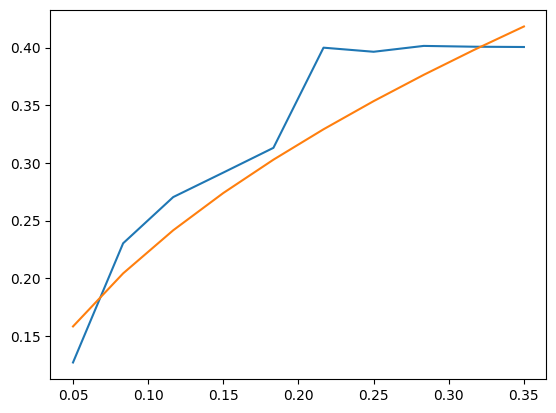

In [177]:
plt.plot(d_list, a_list)
plt.plot(d_list, get_theoretical_contact_radius(R, d_list))

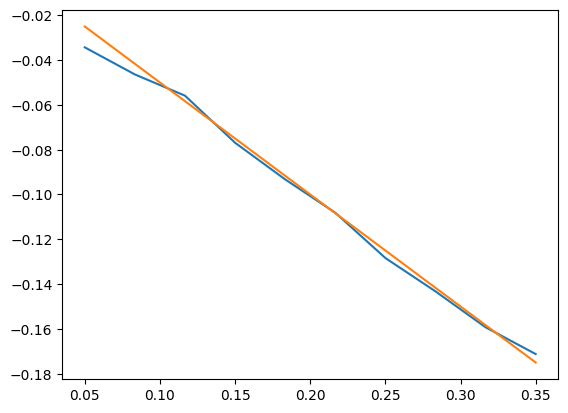

In [178]:
plt.plot(d_list, u_list)
plt.plot(d_list, get_theoretical_normal_displacement(R, d_list, E, nu))